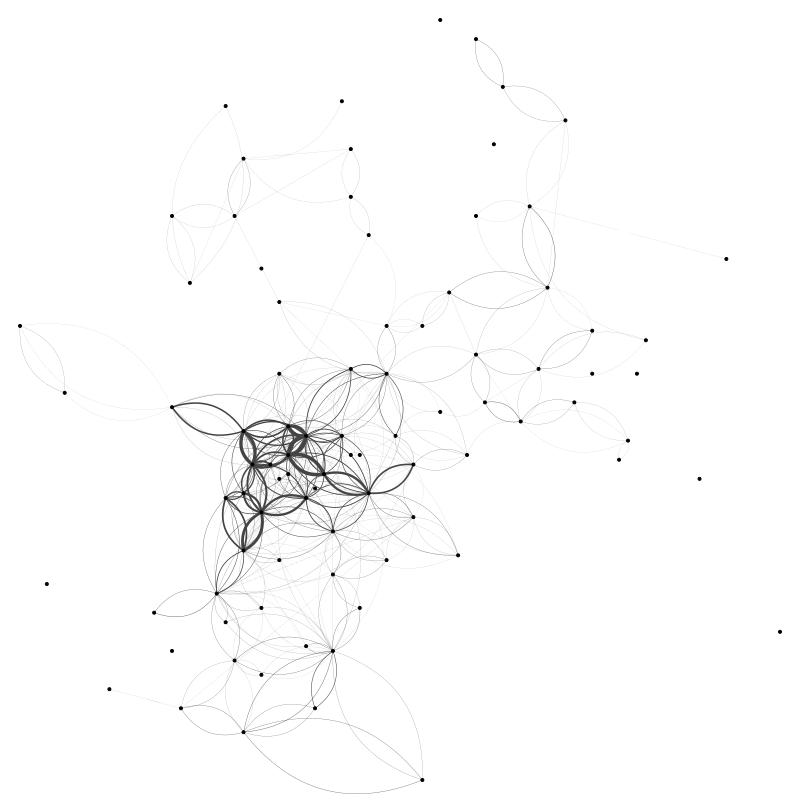

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
import igraph as ig
import sys
sys.path.append('../../src/')
from utils.database import dbutils

connection = dbutils.connect()

foreigners = pd.read_sql(
    "SELECT prev_tower_id, tower_id, count(*) as weight FROM optourism.foreigners_path_records_joined WHERE tower_id != prev_tower_id AND EXTRACT(HOUR FROM date_time_m) = 22 and delta < (INTERVAL '30 minutes') GROUP BY tower_id, prev_tower_id",
    con=connection)
foreigners['tower_id'] = foreigners['tower_id'].apply(lambda x: 'tower-%s' % x)
foreigners['prev_tower_id'] = foreigners['prev_tower_id'].apply(lambda x: 'tower-%s' % x)

tower_vertices = pd.read_sql(
    'SELECT DISTINCT tower_id, lat, lon FROM optourism.foreigners_path_records_joined',
    con=connection
)
tower_vertices['tower_id'] = tower_vertices['tower_id'].apply(lambda x: 'tower-%s' % x)

graph = ig.Graph()
graph.add_vertices(tower_vertices.shape[0])
graph.vs['name'] = tower_vertices['tower_id']
graph.vs['x'] = tower_vertices['lat']
graph.vs['y'] = tower_vertices['lon']

edges = zip(foreigners['prev_tower_id'], foreigners['tower_id'])
graph.add_edges(edges)
graph.es['weight'] = foreigners['weight']
graph.es.select(weight_lt=5).delete()

visual_style = {}
visual_style['edge_width'] = [.01*i for i in graph.es["weight"]] # Scale weights
visual_style['vertex_color'] = 'black'
visual_style['vertex_size'] = 3

ig.plot(graph, bbox = (800,800), **visual_style)
